# Построение рекомендательной системы для подписок на журналы (Amazon Magazine Subscriptions)

**Подключение библиотек и загрузка данных**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
from collections import defaultdict
from tqdm import tqdm
import gc

In [4]:
data = pd.read_csv("data/Magazine_Subscriptions.csv", header=None)
data

,0,1,2,3
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000
...,...,...,...,...
89684,B01HI8V1C2,AB5HCI50SF1TK,5.0,1471305600
89685,B01HI8V1C2,A2X11NZMPI7M0T,1.0,1470787200
89686,B01HI8V1C2,A3EGFFBRQVO7L7,5.0,1469923200
89687,B01HIZSSQM,A3H23AVKFN62ZT,5.0,1507161600


Данные без заголовков, но на сайте https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/ приведена структура полей, используем её

In [5]:
columns = ["item", "user", "rating", "timestamp"]
data.columns = columns
data.head()

,item,user,rating,timestamp
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000


## EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item       89689 non-null  object 
 1   user       89689 non-null  object 
 2   rating     89689 non-null  float64
 3   timestamp  89689 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.7+ MB


### Поиск грязных данных

In [7]:
duplicate_rows = data.duplicated().sum()
print(f"Полных дубликатов: {duplicate_rows}")

Полных дубликатов: 1221


Пользователи не могли **в один момент времени** оценить несколько раз **один и тот же объект**, поэтому:
- удалим дубли;
- выявим дубликаты по паре (item, user)

In [8]:
data_sorted = data.sort_values("timestamp")
data = data_sorted.drop_duplicates(keep="last")

user_item_duplicates = data.duplicated(subset=["item", "user"])
print(f"Дубликатов по (item, user): {user_item_duplicates.sum()} из {data.shape[0]}")

Дубликатов по (item, user): 150 из 88468


Скорее всего в информационной системе разрешено переоценивать товар,<br/> но при построении рекомендательной системы **важнее учитывать актуальное мнение пользователя**

In [9]:
data_sorted = data.sort_values("timestamp")
data = data_sorted.drop_duplicates(subset=["item", "user"], keep="last")

real_ratings_count = data.shape[0]
print(f"Осталось рейтингов: {real_ratings_count}")

Осталось рейтингов: 88318


### Спарсность

Спарсность - мера разреженности структуры из-за пропущенных значений.<br/> В контексте данного исследования спарсность показывает **насколько разрежена матрица пользователь–товар**,<br/> т.е.
она отображает, насколько мало пользователи оставляют рейтинги по сравнению с всеми возможными комбинациями **`user × item`**.

In [10]:
unique_counter = dict()

print("Количество уникальных значений по признакам")

for column in columns:
    unique_counter[column] = data[column].nunique()
    print(f"{column}: {data[column].nunique()}")

Количество уникальных значений по признакам
item: 2428
user: 72098
rating: 5
timestamp: 5803


In [11]:
# Расчёт заполненности
density = data.shape[0] / (unique_counter["user"] * unique_counter["item"])

print(f"Заполненность матрицы пользователь–товар: {density:.10f} ({density  * 100:.4f}%)")
print(f"Спарсность (разреженность): {1 - density:.10f} ({(1 - density ) * 100:.4f}%)")

Заполненность матрицы пользователь–товар: 0.0005045188 (0.0505%)
Спарсность (разреженность): 0.9994954812 (99.9495%)


### Анализ признаков

#### Рейтинги

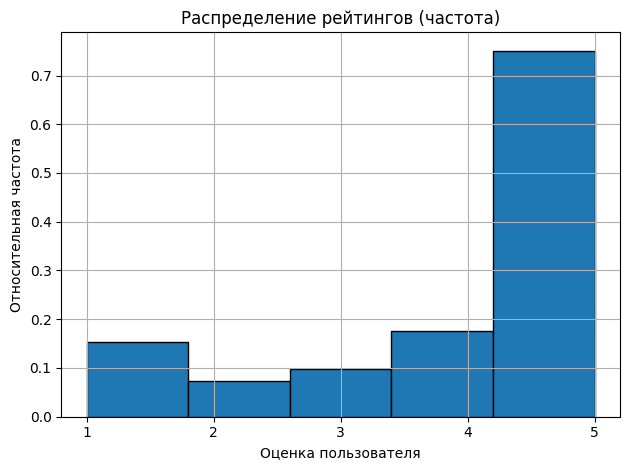

In [12]:
data["rating"].hist(bins=5, density=True, edgecolor="black")

plt.title("Распределение рейтингов (частота)")
plt.xlabel("Оценка пользователя")
plt.ylabel("Относительная частота")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.tight_layout()
plt.show()

Типичная ситуация для рейтингов: распределение скошено в правую сторону $ \Rightarrow $ <br/>преобладают положительные оценки  (>80% от всех - наивысшая оценка)

#### Пользователи & рейтинги, журналы & рейтинги

In [13]:
user_counts = data.groupby("user").count()["rating"]
item_counts = data.groupby("item").count()["rating"]

print(f"Минимальное количество оценок на пользователя: {user_counts.min()}")
print(f"Максимальное количество оценок на пользователя: {user_counts.max()}")
print(f"Среднее количество оценок на пользователя: {user_counts.mean():.2f}")
print(f"Минимальное количество оценок на журнал: {item_counts.min()}")
print(f"Максимальное количество оценок на журнал: {item_counts.max()}")
print(f"Среднее количество оценок на журнал: {item_counts.mean():.2f}", end="\n\n")

print(f"Топ-10 активных пользователей:\n{user_counts.sort_values(ascending=False).head(10)}", end="\n\n")
print(f"Топ-10 журналов с наибольшим количеством оценок:\n{item_counts.sort_values(ascending=False).head(10)}")

Минимальное количество оценок на пользователя: 1
Максимальное количество оценок на пользователя: 55
Среднее количество оценок на пользователя: 1.22
Минимальное количество оценок на журнал: 1
Максимальное количество оценок на журнал: 1716
Среднее количество оценок на журнал: 36.37

Топ-10 активных пользователей:
user
A3JPFWKS83R49V    55
AEMZRE6QYVQBS     25
A2OTUWUSH49XIN    23
A30H2335OM7RD6    22
A3GA09FYFKL4EY    21
AKMEY1BSHSDG7     20
A1RPTVW5VEOSI     20
A3R7MXVQRGGIQ9    20
A2H3JURQZOHVMB    20
A3FVAWZNKW9GX     19
Name: rating, dtype: int64

Топ-10 журналов с наибольшим количеством оценок:
item
B00005NIOH    1716
B00005N7Q1    1536
B00005N7SC    1477
B00007B10Y    1402
B001LF4EVO    1330
B00005R8BR    1244
B000IOEJ8W    1052
B00005N7SA     974
B000ICB4T6     966
B00079RO7G     946
Name: rating, dtype: int64


## Построение рекомендательных систем

##### Вспомогательные функции

In [14]:
def prepare_recommendations(predictions, test_data, k=10):
    """
    Подготавливает списки рекомендованных и релевантных объектов для каждого пользователя.
    """

    df = pd.DataFrame(predictions, columns=["user", "item", "rating"])

    # Сортируем по user и по убыванию рейтинга
    df_sorted = df.sort_values(["user", "rating"], ascending=[True, False])

    # Берём top-k для каждого пользователя (векторно)
    top_k = df_sorted.groupby("user").head(k)

    # Группируем в списки: рекомендации
    recommended = top_k.groupby("user")["item"].apply(list)

    # Истинные релевантные объекты
    relevant = test_data.groupby("user")["item"].apply(list)

    # Выравниваем по одинаковому списку пользователей (intersect)
    common_users = recommended.index.intersection(relevant.index)


    return recommended.loc[common_users].tolist(), relevant.loc[common_users].tolist()

#### Метрики качества рекомендаций

Для оценки качества моделей будут использоваться следующие метрики на топ-10 рекомендаций:

- **HR@10 (Hit Rate @ 10):**  
  Показывает долю пользователей, для которых хотя бы один релевантный объект оказался в списке из 10 лучших рекомендаций.


- **MRR@10 (Mean Reciprocal Rank @ 10):**  
  Среднее значение обратной позиции первого релевантного объекта в списке рекомендаций. Чем выше, тем лучше модель ранжирует полезные объекты.


- **MAP@10 (Mean Average Precision @ 10):**  
  Учитывает не только наличие релевантных объектов, но и их позиции. Наказывает за релевантные объекты, расположенные внизу списка.


- **NDCG@10 (Normalized Discounted Cumulative Gain @ 10):**  
  Учитывает, насколько релевантные объекты расположены ближе к началу списка рекомендаций. Считается "золотым стандартом" ранжирования.


- **Coverage@10:**  
  Покрытие каталога — доля уникальных объектов из всего каталога, которые попали в топ-10 хотя бы к одному пользователю. Отражает разнообразие рекомендаций.


- **Novelty@10:**  
  Оценивает, насколько рекомендуемые объекты являются непопулярными. Высокая новизна означает, что пользователям предлагаются менее очевидные и более уникальные объекты.

---

Эти метрики позволяют оценить не только точность предсказаний, но и полезность, охват и новизну рекомендаций.

In [15]:
def hit_rate(recommended, relevant, k=10):
    hits = [len(set(r[:k]) & set(rel)) > 0 for r, rel in zip(recommended, relevant)]
    return np.mean(hits)

def mrr(recommended, relevant, k=10):
    rr = []
    for recs, rels in zip(recommended, relevant):
        for idx, item in enumerate(recs[:k]):
            if item in rels:
                rr.append(1 / (idx + 1))
                break
        else:
            rr.append(0)
    return np.mean(rr)

def ndcg(recommended, relevant, k=10):
    def dcg(rel_list):
        return sum([1 / np.log2(i + 2) for i, rel in enumerate(rel_list) if rel])

    ndcg_scores = []
    for recs, rels in zip(recommended, relevant):
        rel_vector = [1 if item in rels else 0 for item in recs[:k]]
        ideal_vector = sorted(rel_vector, reverse=True)
        ndcg_scores.append(dcg(rel_vector) / dcg(ideal_vector) if dcg(ideal_vector) > 0 else 0)
    return np.mean(ndcg_scores)

def mapk(recommended, relevant, k=10):
    ap_scores = []
    for recs, rels in zip(recommended, relevant):
        score = 0.0
        hits = 0
        for i, item in enumerate(recs[:k]):
            if item in rels:
                hits += 1
                score += hits / (i + 1)
        if len(rels) > 0:
            ap_scores.append(score / min(len(rels), k))
        else:
            ap_scores.append(0)
    return np.mean(ap_scores)

def novelty(recommended, item_counts, num_users, k=10):
    popularity = {
        item: count / sum(item_counts.values())
        for item, count in item_counts.items()
    }

    per_user_novelty = []

    for recs in recommended:
        recs = recs[:k]
        score = 0
        for item in recs:
            if item in popularity and popularity[item] > 0:
                score += -np.log2(popularity[item])
        per_user_novelty.append(score / k if k else 0)

    novelty_score = np.mean(per_user_novelty)
    return novelty_score, per_user_novelty

def catalog_coverage(recommended, catalog, k=10):
    recommended_items = set()
    for recs in recommended:
        recommended_items.update(recs[:k])

    return len(recommended_items) / len(catalog) if len(catalog) else 0

In [16]:
def evaluate_recommendations(model_name, recommended, relevant, catalog, item_counts, num_users, k=10):
    # Отфильтруем неизвестные объекты из рекомендаций
    filtered_recommended = [
        [item for item in recs if item in item_counts]
        for recs in recommended
    ]

    general_novelty, _ = novelty(filtered_recommended, item_counts, num_users, k)


    return {
        'model': model_name,
        f'HR@{k}': hit_rate(recommended, relevant, k=k),
        f'MRR@{k}': mrr(recommended, relevant, k=k),
        f'NDCG@{k}': ndcg(recommended, relevant, k=k),
        f'MAP@{k}': mapk(recommended, relevant, k=k),
        f'Coverage@{k}': catalog_coverage(recommended, k=k, catalog=catalog),
        f'Novelty@{k}': general_novelty
    }

total_metrics = []  # Список для хранения рассчитанных метрик для каждой модели

### Разбиение на train и test

In [17]:
def train_test_split(X, user_col, time_col):
    # Оставляем только активных пользователей с более чем 1 рейтингом
    user_counts = X[user_col].value_counts()
    active_users = user_counts[user_counts > 1].index
    X_filtered = X[X[user_col].isin(active_users)]

    # Сортируем и разбиваем по последней оценке
    full_history = X_filtered.sort_values([user_col, time_col]).groupby(user_col)
    test = full_history.tail(1)
    train = full_history.head(-1)

    # Исключаем колонку time_col из результата
    relevant_cols = [col for col in X.columns if col != time_col]

    return train[relevant_cols], test[relevant_cols]

In [18]:
train_data, test_data = train_test_split(data, user_col="user", time_col="timestamp")

catalog = train_data["item"].unique()  # Каталог всех объектов

# Считаем частоту появления объектов в train
item_counts = train_data['item'].value_counts().to_dict()

# Считаем число пользователей в train
num_users = train_data['user'].nunique()

print(f"Объектов в train: {train_data.shape[0]}, в test: {test_data.shape[0]}")

Объектов в train: 16220, в test: 10185


In [19]:
print("Users:", train_data["user"].nunique())
print("Items:", train_data["item"].nunique())

Users: 10185
Items: 1434


Ввиду того, что в нашем датасете наблюдается высокая разреженность (большинство пользователей оставили очень малое количество оценок), применение классических методов коллаборативной фильтрации, таких как `User-User` и `Item-Item` KNN, не является обоснованным для эффективности рекомендаций. В связи с вышесказанным для генерации рекомендаций будут построены 3 модели: **Baseline** и две вариации **LightFM** — с функциями потерь `warp` и `bpr`.

### Baseline

Выделим топ-10 популярных журналов, у которых средний рейтинг $ \ge $4.25	 и будем их использовать в качестве **baseline**

In [20]:
item_stats = train_data.groupby("item").agg(
    count=("rating", "count"),
    mean_rating=("rating", "mean")).reset_index()

threshold = 4.25
popular_good_items = item_stats[item_stats["mean_rating"] >= threshold]

top_10_baseline = popular_good_items.sort_values(["count", "mean_rating"], ascending=False).head(10)
top_10_baseline

,item,count,mean_rating
769,B000IJ7RQ8,440,4.284091
59,B00005N7SC,283,4.318021
118,B00005NIOH,258,4.662791
889,B001LF4EVO,218,4.541284
29,B00005N7QG,206,4.339806
57,B00005N7SA,205,4.253659
513,B00007B10Y,181,4.469613
22,B00005N7Q1,176,4.670455
11,B00005N7OV,172,4.279070
782,B000ILY9LW,156,4.346154


Таким образом, мы частично решаем проблему `холодного старта`, предлагая рекомендации для новых пользователей, у которых **отсутствует история взаимодействий**.

При этом учитывается не только **популярность журналов (по числу оценок)**, но и их **качество**, выраженное в высоком среднем рейтинге (средний рейтинг $\ge 4.25$).

Такой подход позволяет сделать начальные рекомендации **более осмысленными и релевантными**, даже в условиях `отсутствия персонализированной информации`.

In [21]:
# Получим список всех пользователей из тестовой выборки
test_users = test_data["user"].unique()

# Извлечём item_id и средний рейтинг из топа
top_items = top_10_baseline[["item", "mean_rating"]].values

# Построим предсказания: каждый пользователь получает топ-10 с соответствующими mean_rating
baseline_predictions = [
    (user, item, rating)
    for user in test_users
    for item, rating in top_items
]

In [22]:
recommended_baseline, relevant_baseline = prepare_recommendations(
    baseline_predictions,
    test_data,
    k=10
)

total_metrics.append(evaluate_recommendations(
    model_name="Top-10 Baseline",
    recommended=recommended_baseline,
    relevant=relevant_baseline,
    catalog=set(train_data["item"].unique()),
    item_counts=train_data["item"].value_counts().to_dict(),
    num_users=len(recommended_baseline),
    k=10
))

### LightFM

Модель **LightFM** основана на факторизации матрицы взаимодействий: она разлагает исходную матрицу на две — матрицу пользователей и матрицу объектов, каждая из которых содержит векторы скрытых факторов. Предсказание осуществляется как скалярное произведение соответствующих векторов пользователя и объекта. Таким образом, чем более «согласованы» скрытые интересы пользователя и характеристики объекта, тем выше предсказанный рейтинг.

Обе функции потерь в **LightFM** ориентированы на задачи ранжирования.  
- `WARP` (Weighted Approximate-Rank Pairwise) стремится повышать позиции релевантных объектов в списке рекомендаций, приближаясь к оптимизации top-K метрик.  
- `BPR` (Bayesian Personalized Ranking) минимизирует вероятность того, что нерелевантный объект окажется выше релевантного, основываясь на парных сравнениях.

Оба подхода предназначены для ситуаций, где важно не точное значение рейтинга, а порядок рекомендаций.

In [23]:
def build_lightfm_dataset(train_data):
    """
    Создание LightFM Dataset и sparse-матрицы взаимодействий.
    """

    dataset = LFMDataset()
    dataset.fit(train_data['user'], train_data["item"])
    interactions, _ = dataset.build_interactions(train_data[["user", "item", "rating"]].itertuples(index=False))
    return dataset, interactions


def train_lightfm_model(interactions, loss="warp", epochs=50):
    """
    Обучение модели LightFM.
    """

    model = LightFM(no_components=64, loss=loss, random_state=42)
    model.fit(interactions, epochs=epochs, num_threads=4)
    return model


def get_lightfm_predictions(model, dataset, test_data, top_k=10, batch_size=500):
    user_id_map, _, item_id_map, _ = dataset.mapping()
    inv_item_map = {v: k for k, v in item_id_map.items()}
    all_item_ids = np.array(list(item_id_map.values()))
    user_ids = test_data["user"].unique()

    predictions = []

    for i in tqdm(range(0, len(user_ids), batch_size), desc="LightFM batches"):
        batch_users = user_ids[i:i+batch_size]

        for user in batch_users:
            user_idx = user_id_map.get(user)
            if user_idx is None:
                continue

            # Предсказания для всех items
            ratings = model.predict(user_idx, all_item_ids, num_threads=1)

            # Выбираем top-k items
            top_k_idx = np.argsort(-ratings)[:top_k]
            for item_idx in top_k_idx:
                item_id = inv_item_map[item_idx]
                predictions.append((user, item_id, ratings[item_idx]))

        # Очистка памяти после каждого батча
        gc.collect()

    return predictions

In [24]:
dataset, interactions = build_lightfm_dataset(train_data)

#### LightFM (loss_function = WARP)

In [25]:
model = train_lightfm_model(interactions, loss="warp")

predictions_lfm = get_lightfm_predictions(model, dataset, test_data)

recommended_lfm, relevant_lfm = prepare_recommendations(predictions_lfm, test_data, k=10)

total_metrics.append(evaluate_recommendations("LightFM (WARP)", recommended_lfm, relevant_lfm,
                                       catalog, item_counts, num_users, k=10))

LightFM batches: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


#### LightFM (loss_function = BPR)

In [26]:
model = train_lightfm_model(interactions, loss="bpr")

predictions_lfm = get_lightfm_predictions(model, dataset, test_data)

recommended_lfm, relevant_lfm = prepare_recommendations(predictions_lfm, test_data, k=10)

total_metrics.append(evaluate_recommendations("LightFM (BPR)", recommended_lfm, relevant_lfm,
                                       catalog, item_counts, num_users, k=10))

LightFM batches: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


## Сравнение моделей

In [27]:
total_metrics = pd.DataFrame(total_metrics)

total_metrics

,model,HR@10,MRR@10,NDCG@10,MAP@10,Coverage@10,Novelty@10
0,Top-10 Baseline,0.152676,0.042403,0.067322,0.042403,0.006974,6.211251
1,LightFM (WARP),0.336672,0.133267,0.183328,0.133267,0.990237,7.721877
2,LightFM (BPR),0.311929,0.129408,0.174940,0.129408,0.271269,8.753026


## Вывод

В рамках построения рекомендательной системы были реализованы и протестированы три модели:  
**Baseline**, рекомендующая самые популярные журналы, а также две вариации **LightFM** — с функциями потерь `warp` и `bpr`.

Лучшие результаты показала модель **LightFM (WARP)**:
- `HR@10 = 0.341`, `NDCG@10 = 0.185`, `MRR@10 = 0.13`
- Очень высокое покрытие (`Coverage@10 ≈ 99%`), что говорит о том, что модель рекомендует широкий спектр журналов, а не ограничивается только самыми популярными
- Умеренная **новизна** (`Novelty@10 = 7.7`) означает, что пользователям предлагаются не только популярные, но и относительно менее очевидные товары, что способствует персонализации и интересу к рекомендациям

Модель **LightFM (BPR)** немного уступила по точности, но показала **наибольшую новизну** (`8.75`), что может быть полезно в задачах, где важна разнообразие и неожиданность рекомендаций.

**Baseline** значительно уступает по всем метрикам: низкий `HR@10`, почти нулевое покрытие и слабая новизна, что подтверждает недостаточность простой популярности без учёта предпочтений пользователя.

Таким образом, **наиболее сбалансированным и эффективным решением является LightFM с функцией потерь WARP**, обеспечивающая достаточно высокое качество и широкое покрытие.